In [44]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union, polygonize
import osmnx as ox
import neatnet
import matplotlib.pyplot as plt

In [45]:

dist = 2800

from types import SimpleNamespace

# Define all cities in one namespace
cities = SimpleNamespace(
    barc=SimpleNamespace(name="Barcelona", coord=(41.381426, 2.173053), crs=25831),
    ath=SimpleNamespace(name="Athens", coord=(37.989702027509686, 23.738142824327344), crs=2100),
    tyo=SimpleNamespace(name="Tokyo", coord=(35.702950, 139.769753), crs=3099),
    lbrgh=SimpleNamespace(name="Loughborough", coord=(52.767225, -1.220030), crs=27700),
    mk=SimpleNamespace(name="Milton Keynes", coord=(52.0406, -0.7594), crs=27700),
    ldn=SimpleNamespace(name="London - Camden", coord=(51.543001, -0.183654), crs=27700)  # NEW
)

# Choose the city prefix you want to analyze
selected_city_key = 'lbrgh'  # Switch to 'ath' or 'barc' etc.

# Create a reference to the selected city
city = getattr(cities, selected_city_key)

Downloaded street network for (52.767225, -1.22003)


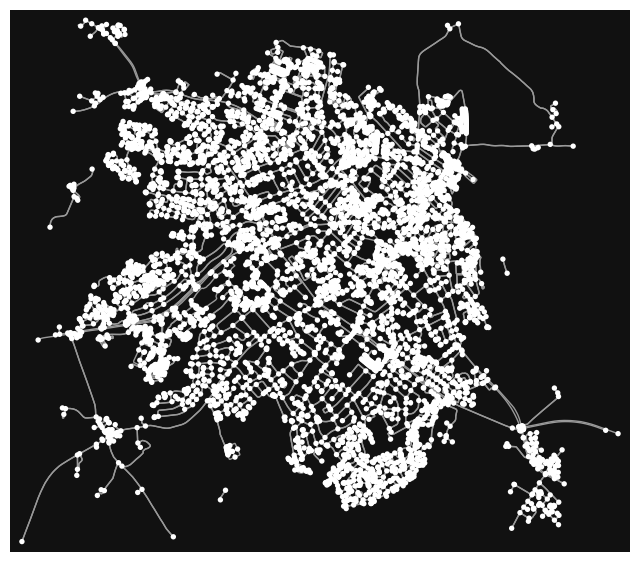

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [46]:

center_point = city.coord
custom_filter = (
    '["highway"~"motorway|trunk|primary|secondary|tertiary|footway|pedestrian|path|steps"]'
)
custom_filter1 = '["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|service"]'	

osm_graph=ox.graph.graph_from_point(
    center_point, 
    dist, 
    dist_type='bbox', 
    network_type= 'drive', # "all_public", "all", "bike", "drive", "drive_service", "walk"
    simplify=True, 
    retain_all=True, 
    truncate_by_edge=True, 
    custom_filter=custom_filter1)

print(f"Downloaded street network for {center_point}")

ox.plot_graph(osm_graph)

In [47]:
# you already built `osm_graph` above
G = osm_graph

# Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Ensure WGS84 (GeoJSON expects lon/lat)
nodes_gdf = nodes_gdf.to_crs(epsg=4326)
edges_gdf = edges_gdf.to_crs(epsg=4326)

# Write out as GeoJSON (separate files: points + lines)
#nodes_gdf.to_file("street_nodes.geojson", driver="GeoJSON")
#edges_gdf.to_file("street_edges.geojson", driver="GeoJSON")

print("Saved GeoJSON: street_nodes.geojson and street_edges.geojson")

Saved GeoJSON: street_nodes.geojson and street_edges.geojson


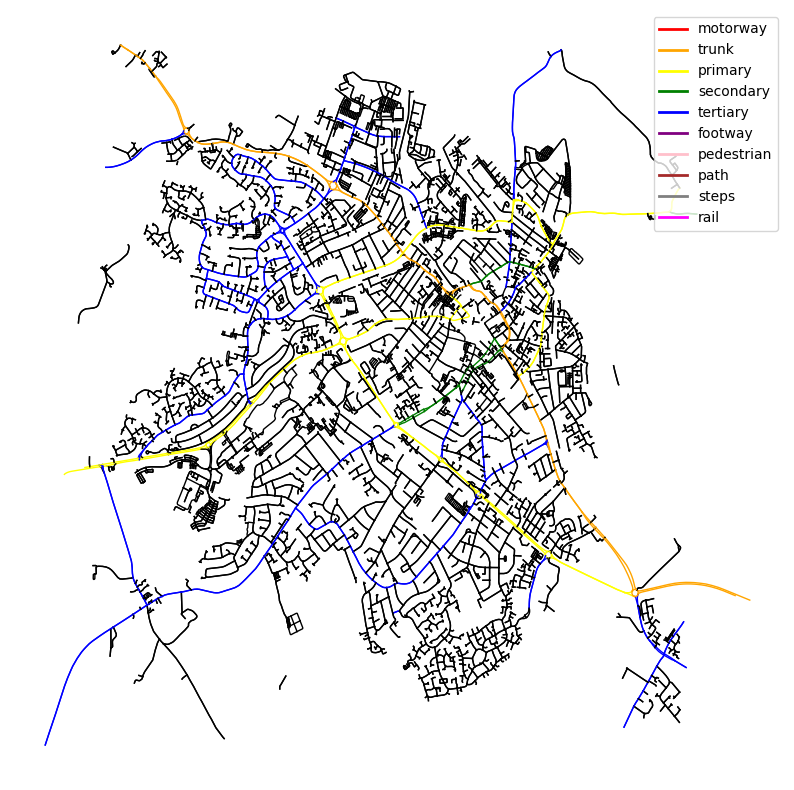

In [48]:

road_colors = {
    'motorway': 'red',
    'trunk': 'orange',
    'primary': 'yellow',
    'secondary': 'green',
    'tertiary': 'blue',
    'footway': 'purple',
    'pedestrian': 'pink',
    'path': 'brown',
    'steps': 'gray',
    'rail': 'magenta'
}
edges = ox.graph_to_gdfs(osm_graph, nodes=False, edges=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Loop through each road and plot with its color
for idx, row in edges.iterrows():
    # Sometimes highway is a list, sometimes a string
    highway_type = row['highway']
    if isinstance(highway_type, list):
        highway_type = highway_type[0]  # take the first one

    color = road_colors.get(highway_type, 'black')  # default to black if not found
    g = row['geometry']
    if g is not None:
        if g.geom_type == 'LineString':
            ax.plot(*g.xy, color=color, linewidth=1)
        elif g.geom_type == 'MultiLineString':
            for linestring in g:
                ax.plot(*linestring.xy, color=color, linewidth=1)

# Set axis off
ax.axis('off')

# Optional: add a legend manually
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=road_type)
    for road_type, color in road_colors.items()
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

In [49]:

# Project to a local CRS for accurate buffering
osm_graph = ox.projection.project_graph(osm_graph, to_crs=city.crs)  # EPSG:2100 for Greece

#get the edges (streets) and convert them to gdf
streets = ox.graph_to_gdfs(
    ox.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)

print(f"🔎 Found {len(streets)} edges total.")
print("Unique 'highway' tags in this area:")
print(streets['highway'].explode().unique())  # .explode() handles lists of tags
#print (streets)

🔎 Found 6540 edges total.
Unique 'highway' tags in this area:
<StringArray>
[         'trunk',   'unclassified',        'service',    'residential',
       'tertiary',        'primary',  'tertiary_link',      'secondary',
     'trunk_link',   'primary_link', 'secondary_link']
Length: 11, dtype: str


✅ Created 860 polygons from buffered walk network.


<Axes: >

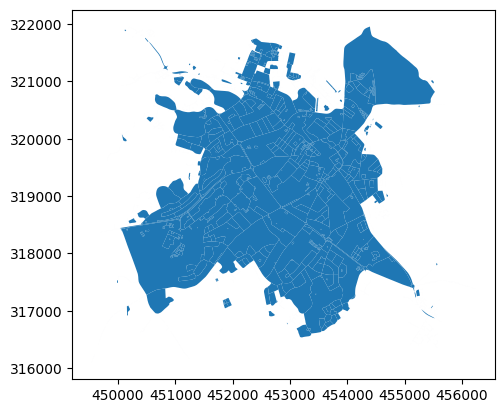

In [50]:

# Apply a small buffer to thicken the lines (try 2-3 meters)
buffered_edges = streets.buffer(0.02)

# Merge all the buffered geometries into one shape
merged = unary_union(buffered_edges)

# Polygonize the merged shape
block_polygons = list(polygonize(merged))

# Convert to GeoDataFrame
blocks = gpd.GeoDataFrame(geometry=block_polygons, crs=city.crs)

# Reproject back to lat/lon if needed
#blocks = blocks.to_crs(epsg=4326)

print(f"✅ Created {len(blocks)} polygons from buffered walk network.")

# 9️⃣ Plot
blocks.plot()

In [51]:
buildings = (
    ox.features.features_from_point(
        center_point=city.coord,
        dist=dist,
        tags={"building": True}
    )
    .query('building != "roof"')
    .to_crs(city.crs)
)
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

In [52]:
# Optional, export buildings: 

drop_cols = [c for c in [
    "nodes", "ways", "tags", "timestamp", "version", "changeset", "uid", "user"
] if c in buildings.columns]

buildings_out = buildings.drop(columns=drop_cols).copy()
buildings_out["geometry"] = buildings_out.geometry.buffer(0)
buildings_out = buildings_out.to_crs(epsg=4326)
buildings_out.to_file("buildings.geojson", driver="GeoJSON")

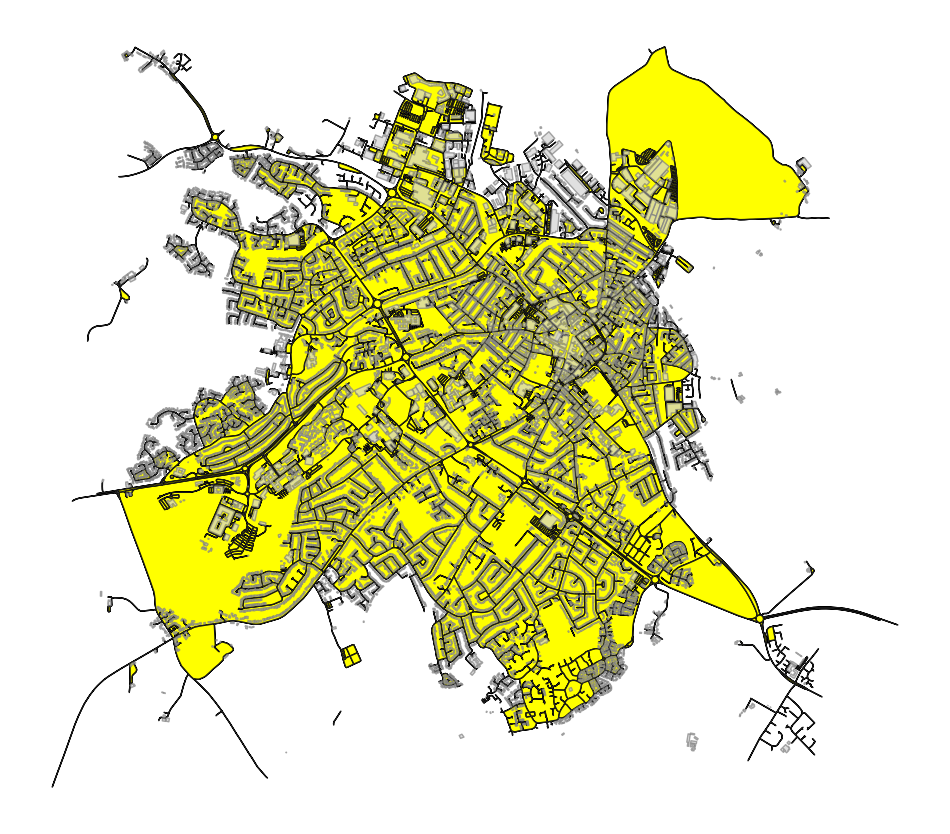

In [53]:
ax = streets.plot(figsize=(12, 12), linewidth=0.1, color='lightgrey', alpha =0.8)  # black streets
blocks.plot (ax=ax, facecolor = 'yellow', edgecolor='black')
buildings.plot(ax=ax, facecolor='lightgrey', edgecolor='grey', alpha=0.7)
ax.set_axis_off()

# 1. Main Statistics of Building footprints:

Calculate area, perimeter, centroid and Orientation of each building

Why this matters?

Blocks with low orientation variance (e.g. std_orientation < 20°) likely have consistent, regular building alignment (e.g. rowhouses or perimeter blocks).

Blocks with high orientation variance have a more organic, irregular layout (e.g. older areas, mixed-use development).

In [54]:
# get main building stats and centroid: 

buildings_with_stats = buildings.copy()
buildings_with_stats['area'] = buildings_with_stats.geometry.area
buildings_with_stats['perimeter'] = buildings_with_stats.geometry.length
buildings_with_stats['centroid'] = buildings_with_stats.geometry.centroid


In [55]:
# Get orientation of buildings

def calculate_orientation(polygon):
    mbr = polygon.minimum_rotated_rectangle
    coords = list(mbr.exterior.coords)
    if len(coords) < 2:
        return np.nan  # skip invalid shapes
    edge_vector = np.array(coords[1]) - np.array(coords[0])
    angle = np.arctan2(edge_vector[1], edge_vector[0])
    return np.degrees(angle) % 180  # 0-180 degrees

# Apply to each building
buildings_with_stats["orientation"] = buildings_with_stats.geometry.apply(calculate_orientation)

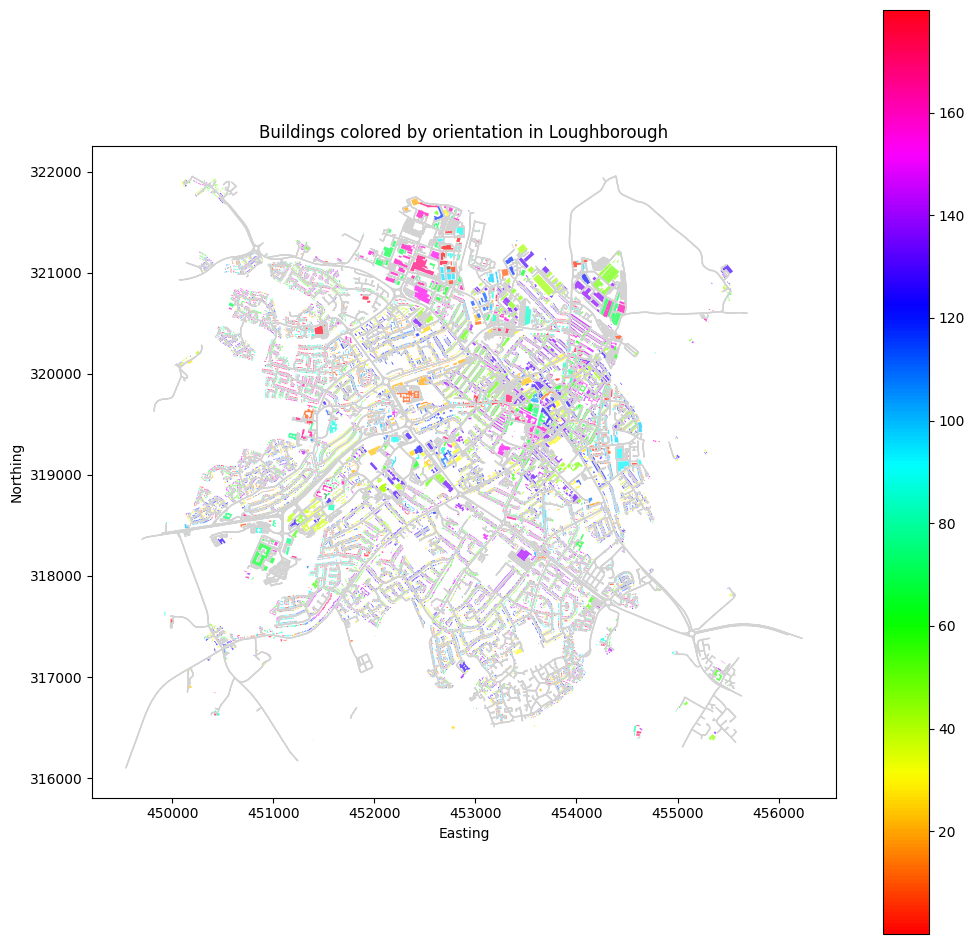

In [56]:
# Plot buildings colored by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot blocks boundaries in light gray
blocks.boundary.plot(ax=ax, color='lightgray', linewidth=1)

# Plot buildings colored by orientation
buildings_with_stats.plot(
    ax=ax,
    column='orientation',
    cmap='hsv',  # or 'viridis', 'plasma', etc.
    legend=True,
    alpha=0.7
)

plt.title(f"Buildings colored by orientation in {city.name}")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

# 2. Spatial Join: Join block index to building centroids: 

In [57]:
#This line Creates a new GeoDataFrame (building_centroids) where it replaces the polygon geometry to 'Point' from the centroid column for more accurate joining. 
#The original building shapes are still in the DataFrame, but they’re no longer the active geometry column.
#This is a safe and temporary way to work with centroids for spatial joins, plots, etc., without modifying the original geometry.

building_centroids = buildings_with_stats.set_geometry('centroid')
#print  (buildings_with_stats['centroid'], building_centroids['centroid'])

# Perform the spatial join with centroids for getting building no per block
building_centroids_with_blocks = gpd.sjoin(
    building_centroids,
    blocks,
    how='inner',
    predicate='within'
)

print(f"✅ Joined {len(building_centroids_with_blocks )} buildings to blocks.")

✅ Joined 11159 buildings to blocks.


# 3. Main Statistics of Blocks: 

calculate area, building area, sdrd deviation, building count, 

In [58]:
# Group building centroids with stats by block index and calculate aggregates.
building_groups = building_centroids_with_blocks.groupby('index_right')
total_building_area = building_groups['area'].sum()
avg_building_area = building_groups['area'].mean()
std_building_area = building_groups['area'].std()
building_count = building_groups.size()

#Blocks with low orientation variance (e.g. std_orientation < 20°) likely have consistent, regular building alignment (e.g. rowhouses or perimeter blocks).
#Blocks with high orientation variance have a more organic, irregular layout (e.g. older areas, mixed-use development).
mean_orientation = building_groups['orientation'].mean()
std_orientation = building_groups['orientation'].std()


# Store results into the blocks
blocks_with_stats = blocks.copy()
blocks_with_stats['block_area'] = blocks_with_stats.geometry.area
blocks_with_stats['total_building_area'] = total_building_area
blocks_with_stats['avg_building_area'] = avg_building_area
blocks_with_stats['std_building_area'] = std_building_area
blocks_with_stats['footprint_ratio'] = (
    blocks_with_stats['total_building_area'] / blocks_with_stats['block_area']
)
blocks_with_stats['building_count'] = building_count
blocks_with_stats['mean_orientation'] = mean_orientation
blocks_with_stats['std_orientation'] = std_orientation
#blocks_with_stats['avg_orientation'] = avg_orientation
# Fill missing values
blocks_with_stats = blocks_with_stats.fillna(0)

print(blocks_with_stats.head())

                                            geometry     block_area  \
0  POLYGON ((449638.639 316360.397, 449638.639 31...   13530.193422   
1  POLYGON ((452651.134 321665.557, 452647.599 32...   12923.416224   
2  POLYGON ((452751.607 321587.311, 452753.899 32...    2522.196857   
3  POLYGON ((452783.561 320847.429, 452783.561 32...  101739.602364   
4  POLYGON ((452751.273 320514.027, 452865.753 32...   14418.391403   

   total_building_area  avg_building_area  std_building_area  footprint_ratio  \
0            37.616643          37.616643           0.000000         0.002780   
1          4899.070531        1224.767633        1043.652012         0.379085   
2           514.891204         514.891204           0.000000         0.204144   
3         19148.176069         348.148656         730.893653         0.188208   
4          3112.928562         107.342364          14.512688         0.215900   

   building_count  mean_orientation  std_orientation  
0             1.0        126.68

### Aspect Ratio
How stretched or elongated the block is 

aspect_ratio = max(width / height, height / width)

E.g.: A square block → width = height → aspect_ratio = 1 | A long narrow block → width = 4, height = 1 → aspect_ratio = 4

High aspect ratio → likely a fishbone or elongated grid.
Near 1 → likely perimeter block or compact grid.

In [59]:
# It works by taking the bounding box of the block, measures its width and height.
# Then gets the ratio between them — always making sure the ratio is ≥1 by flipping if needed.

# Metric functions
def aspect_ratio(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    return max(width / height, height / width)

blocks_with_stats["aspect_ratio"] = blocks_with_stats.geometry.apply(aspect_ratio)

print (blocks_with_stats["aspect_ratio"][0])

1.1422412161035131


### Compactness
How "efficient" the shape is in enclosing space. It penalizes irregular or elongated shapes

compactness = 4π × area / perimeter²

It compares how much area the shape encloses vs. how much perimeter it uses.
A perfect circle has compactness = 1 (maximum efficiency). Square: compactness ~ 0.785.
Long, skinny, or jagged shapes have much lower values.

**Low compactness → likely fishbone or irregular.**
**High compactness → likely grid or perimeter.**

In [60]:
def compactness(poly):
    return 4 * np.pi * poly.area / (poly.length ** 2) if poly.length > 0 else 0

blocks_with_stats["compactness"] = blocks_with_stats.geometry.apply(compactness)
print (blocks_with_stats["compactness"][0])


3.716193027065695e-07


### Convexity 

How "jagged" or indented the shape is.

convexity = area / convex_hull_area

The convex hull is like stretching a rubber band around the shape.
Convexity compares how much space your shape covers vs. that outer band.

A perfectly convex shape (like a rectangle) → convexity = 1. A U-shaped or highly irregular block → convexity < 1

Low convexity → likely irregular.
Near 1 → grid or perimeter block.

In [61]:
def convexity(poly):
    hull = poly.convex_hull
    return poly.area / hull.area if hull.area > 0 else 0
blocks_with_stats["convexity"] = blocks_with_stats.geometry.apply(convexity)

print (blocks_with_stats["convexity"][0])

0.0003963224679625867


# 4. Keep only the blocks that contain at least one building 

In [62]:
# Keep only blocks that contain at least one building  (!! NEEDS BETTER LOGIC TO GET ALL BLOCKS THAT DONT HAVE BUILDINGS BUT REMOVE STREETS) (EXTRACT SQUARES AND PARKS)
blocks_stats_built = blocks_with_stats[blocks_with_stats['building_count'] > 0].copy()
print ("Total buildings per block:", blocks_stats_built['building_count'])


Total buildings per block: 0       1.0
1       4.0
2       1.0
3      55.0
4      29.0
       ... 
829     8.0
830     6.0
843     1.0
846     1.0
848     2.0
Name: building_count, Length: 333, dtype: float64


In [63]:
# optional for exporting blocks to geojson:

#  simplify with e.g. 1–3m tolerance.
blocks_stats_built_simpl = blocks_stats_built.copy()
blocks_stats_built_simpl["geometry"] = blocks_stats_built_simpl.geometry.simplify(2, preserve_topology=True)

export_gdf = blocks_stats_built_simpl.drop(columns=[c for c in ["index_right"] if c in blocks_stats_built.columns])

##You want the CRS transform to EPSG:4326 so MapLibre/most web maps place it correctly
export_gdf = export_gdf.to_crs(epsg=4326)
export_gdf.to_file("blocks.geojson", driver="GeoJSON")

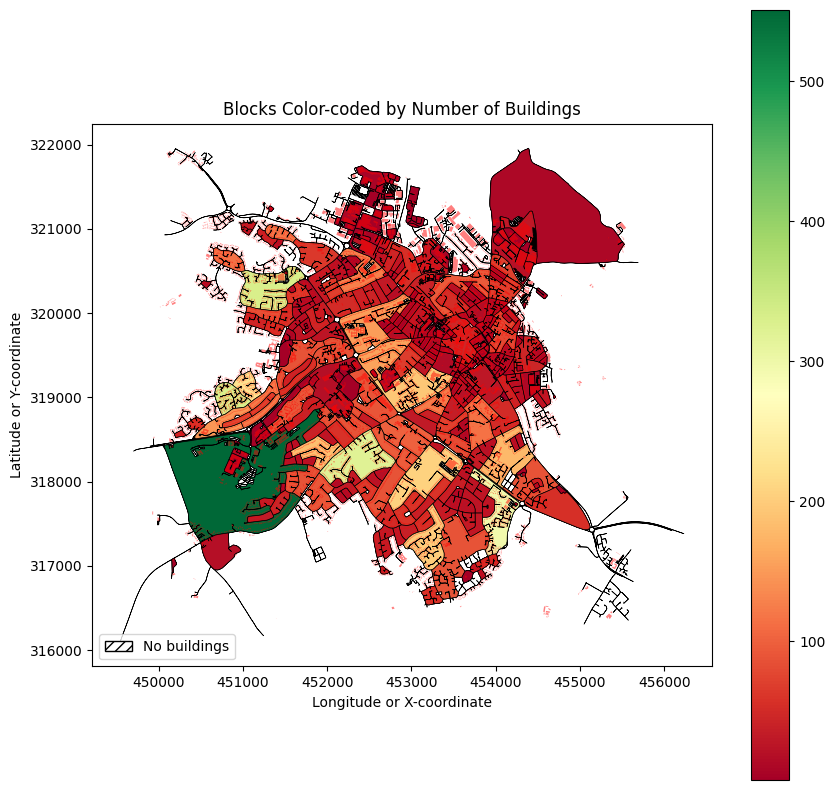

In [64]:
# for plotting purposes only

from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(10, 10))

#for printing purposes only

blocks_stats_built_plot = blocks_stats_built.copy()
# Optional: For plotting purposes, assign NaN where building_count == 0 (though they are now removed)
# This is not needed anymore if you're removing them completely, but if plotting all blocks:
# blocks_with_stats_plot["building_count"] = blocks_with_stats_plot["building_count"].replace(0, np.nan)

# Plot the blocks, color-coded by number of buildings
blocks_stats_built_plot.plot(
    column='building_count',
    ax=ax,
    legend=True,
    cmap='RdYlGn',  # Green (low) to Red (high)
    linewidth=0.5,
    edgecolor='black',
    missing_kwds={
        "color": "white",
        "edgecolor": "black",
        "hatch": "///",
    }
)

# Plot the buildings on top
buildings.plot(
    ax=ax,
    color='red',
    alpha=0.5,
    markersize=2
)

# Add manual legend entry for "No buildings"
legend_patches = [
    Patch(facecolor='white', edgecolor='black', hatch='///', label='No buildings')
]

plt.legend(handles=legend_patches, loc='lower left')

plt.title("Blocks Color-coded by Number of Buildings")
plt.xlabel("Longitude or X-coordinate")
plt.ylabel("Latitude or Y-coordinate")
plt.show()


# Step 1: Define the Classification Rules

We’ll classify each block as one of the following:

"regular_grid", "offset" , "fishbone" , "organic" , "superblock"

In [65]:
# Classification logic
#Square: compactness ~ 0.785. cirle: 1
#A perfectly convex shape (like a rectangle) → convexity = 1. A U-shaped or highly irregular block → convexity < 1

# Density of street network --> hillier and type of area in early space syntax work in london. peponis and 

#superblocks
# internal perubility and external connectivity

#print (blocks_stats_built.head())
def classify_block(row):
    poly = row['geometry']
    asp = aspect_ratio(poly)
    comp = compactness(poly)
    conv = convexity(poly)

    if row['building_count'] < 3:
        return "single plot"
    elif asp > 2 and conv > 0.5 and comp < 0.6:
        return "fishbone"
    elif asp < 2 and conv > 0.8:
        return "perimeter"
    elif comp > 0.5:
        return "grid"
    else:
        return "other"

blocks_stats_built['type'] = blocks_stats_built.apply(classify_block, axis=1)

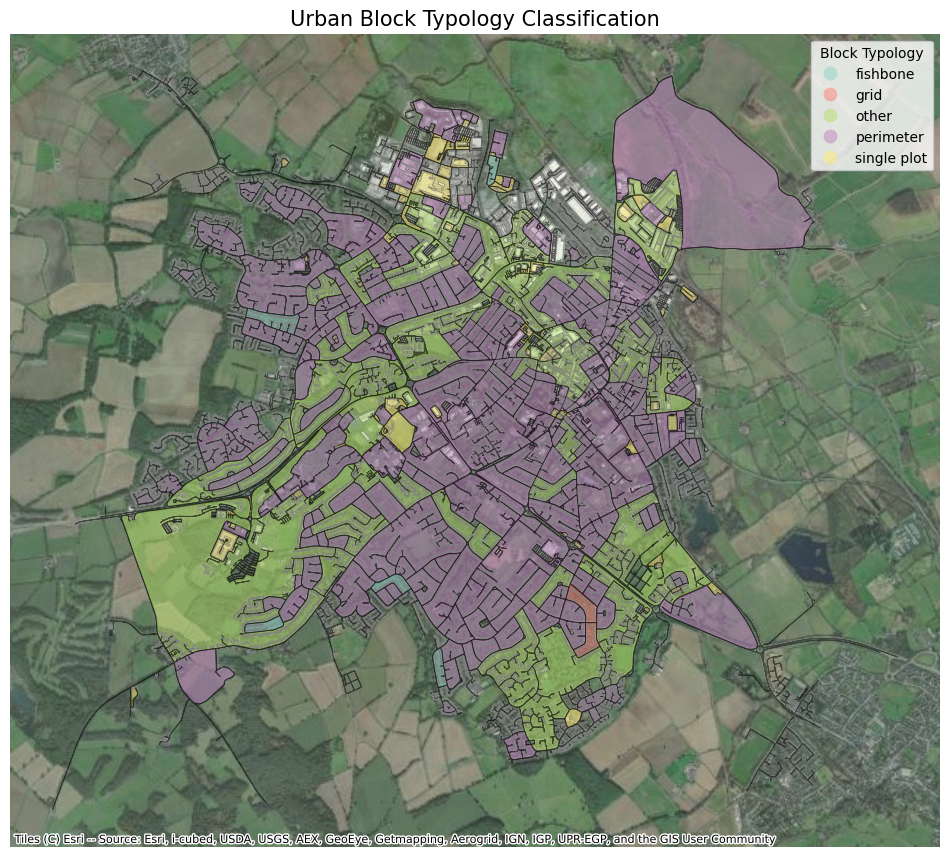

In [66]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(12, 12))

# Plot block typologies
blocks_stats_built.to_crs(epsg=3857).plot(
    column="type",
    ax=ax,
    legend=True,
    cmap="Set3",
    edgecolor="black",
    linewidth=0.7,
    alpha=0.5,
    categorical=True,
    legend_kwds={"title": "Block Typology"}
)

# Plot buildings in grey outline
buildings.to_crs(epsg=3857).plot(
    ax=ax,
    facecolor="none",
    edgecolor="grey",
    linewidth=0.5
)

# Add aerial basemap (Esri World Imagery)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, alpha=0.8)

ax.set_title("Urban Block Typology Classification", fontsize=15)
ax.set_axis_off()

plt.show()

### Export blocks in GeoJson

In [67]:
# Optional, export blocks (drop noisy cols, simplify, fix geom, export to EPSG:4326)
 
buildings_out["geometry"] = buildings_out.geometry.buffer(0)
buildings_out = buildings_out.to_crs(epsg=4326)
buildings_out.to_file("buildings.geojson", driver="GeoJSON")

drop_cols = [c for c in [
    "nodes", "ways", "tags", "timestamp", "version", "changeset", "uid", "user",
    "index_right"  # common join artifact
] if c in blocks_stats_built.columns]

blocks_out = blocks_stats_built.drop(columns=drop_cols).copy()

# Fix invalid geometries
blocks_out["geometry"] = blocks_out.geometry.buffer(0)

# Simplify BEFORE reproject if you're in a metric CRS (e.g. EPSG:27700); tolerance is in CRS units
# Try 1–3 (meters) if EPSG:27700
#blocks_out["geometry"] = blocks_out.geometry.simplify(2, preserve_topology=True)

# Export to web CRS
blocks_out = blocks_out.to_crs(epsg=4326)
blocks_out.to_file("blocks.geojson", driver="GeoJSON")

print("✅ Saved blocks.geojson", len(blocks_out))

✅ Saved blocks.geojson 333


### Classifying block regularity based on the standard deviation of building orientation (std_orientation).

We’ll define a simple rule:   regular if std_orientation < 20°, irregular otherwise

In [68]:
# Classify blocks based on std_orientation
blocks_orientation["regularity"] = blocks_orientation["std_orientation"].apply(
    lambda x: "regular" if x < 20 else "irregular"
)

# Summary count
print(blocks_orientation["regularity"].value_counts())

NameError: name 'blocks_orientation' is not defined

In [ ]:
# Plot blocks colored by regularity
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings in gray
building_with_blocks.plot(ax=ax, color="lightgray", linewidth=0.5, alpha=0.5)

# Plot blocks by typology
blocks_orientation.plot(
    ax=ax,
    column="regularity",
    cmap="Set1",  # Categorical colormap (red & blue)
    legend=True,
    alpha=0.5,
    edgecolor="black"
)

plt.title(f"Block Regularity Classification in {city.name}")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.show()

In [ ]:
def classify_typology(row):
    if row["building_count"] == 1:
        return "Single Building"
    elif row["footprint_ratio"] > 0.5 and row["building_count"] > 4:
        return "Perimeter Block"
    elif row["std_building_area"] > 100 and row["building_count"] > 5:
        return "Organic"
    elif row["std_building_area"] < 50 and row["building_count"] > 5:
        return "Regular Grid"
    elif row["building_count"] >= 3:
        return "Fishbone"
    else:
        return "Unclassified"



In [ ]:
blocks_orientation["typology"] = blocks_orientation.apply(classify_typology, axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))

blocks_orientation.plot(
    column="typology",
    ax=ax,
    legend=True,
    cmap="Set3",  # You can try Set1, Set2, tab10, Pastel1, etc.
    edgecolor="black",
    linewidth=0.3,
    categorical=True,
    legend_kwds={"title": "Block Typology"}
)
# Plot buildings in black
buildings.plot(ax=ax, facecolor="none", edgecolor="grey", linewidth=0.5)

ax.set_title("Urban Block Typology Classification", fontsize=15)
ax.set_axis_off()

plt.show()

## NEATNET

In [ ]:
simplified = neatnet.neatify(streets, exclusion_mask=buildings.geometry)

In [ ]:
ax = streets.plot(figsize=(12, 12), linewidth=0.5)
simplified.plot(color="red", linewidth=0.5, ax=ax)
ax.set_axis_off()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

streets.plot(ax=axs[0], linewidth=0.5)
simplified.plot(color="red", linewidth=0.5, ax=axs[1])
for ax in axs:
    ax.set_xlim(city_centre[0] - 500, city_centre[0] + 500)
    ax.set_ylim(city_centre[1] - 500, city_centre[1] + 500)
    ax.set_axis_off()
axs[0].set_title("original")
axs[1].set_title("simplifiied");

In [ ]:
ax = simplified.plot("_status", figsize=(12, 12), linewidth=0.5, legend=True)
ax.set_axis_off()